Loaded shape: (5572, 2)
Example rows:


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Class distribution (full):
 label_bin
0    4825
1     747
Name: count, dtype: int64

Class distribution (train):
 0    3859
1     598
Name: count, dtype: int64

Class distribution (test):
 0    966
1    149
Name: count, dtype: int64

Decision Stump (max_depth=1) - Train acc: 0.8919, Test acc: 0.8870


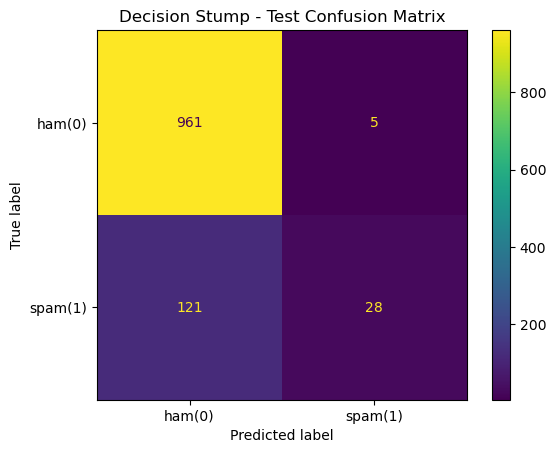


Comment: Decision stumps are very weak on text data because text features are high-dimensional and sparse. A single split (one word TF-IDF threshold) can't capture the complex patterns distinguishing spam from ham. Ensembles that combine many weak rules are needed.

Iteration 1
  Weighted error (err_t): 0.10814449181063497
  Alpha: 1.054917956518916
  Number of misclassified samples (train): 482
  Sample indices (relative to train) of misclassified (first up to 20): [9, 15, 22, 31, 39, 49, 59, 66, 76, 88, 93, 114, 121, 123, 159, 162, 166, 174, 194, 203]
  Weights of these misclassified samples: [0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224]

Iteration 2
  Weighted error (err_t): 0.41560400845533546
  Alpha: 0.17042295829756243
  Number of misclassified samples (train): 514
  Sample indices (relative to train) of misclassified (first 

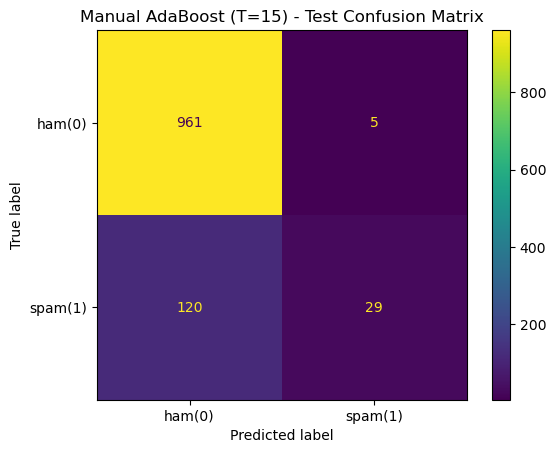

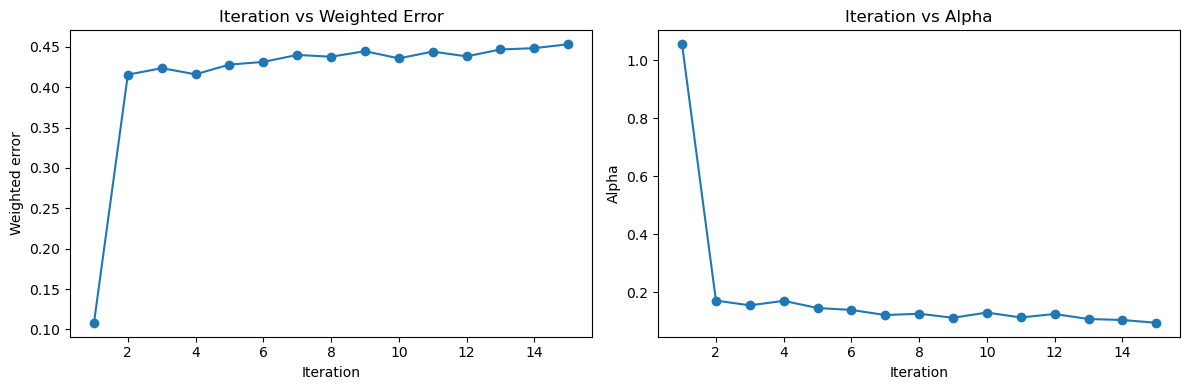


Short interpretation of weight evolution:
 - Samples misclassified in early rounds receive higher weights, forcing later weak learners to focus on them.
 - If a sample is consistently misclassified, its weight grows and the ensemble tries to correct it; noisy or ambiguous samples may thus dominate weights.
 - Alpha values are high when weighted error is low and vice versa.


TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [2]:
# ===========================
# ADABOOST SMS SPAM - All parts A -> D
# Ready to paste into Jupyter Notebook
# ===========================

# CELL 1: imports and constants
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
DATA_PATH = "spam.csv"   # change if needed

# CELL 2: Load dataset robustly (handles 'v1','v2' variants)
df = pd.read_csv("spam.csv", encoding="latin-1")

# keep only first two columns if extra columns exist, try common names
if 'label' in df.columns and 'text' in df.columns:
    df = df[['label', 'text']]
elif 'v1' in df.columns and 'v2' in df.columns:
    df = df.rename(columns={'v1': 'label', 'v2': 'text'})[['label','text']]
else:
    # fallback: take first two cols
    df = df.iloc[:, :2]
    df.columns = ['label','text']

print("Loaded shape:", df.shape)
print("Example rows:")
display(df.head())

# CELL 3: Part A - Preprocessing & Exploration
# 1) Convert labels: spam->1, ham->0
df['label_bin'] = df['label'].str.strip().map({'spam':1, 'ham':0})
if df['label_bin'].isnull().any():
    # try lowercase mapping
    df['label_bin'] = df['label'].str.lower().map({'spam':1,'ham':0})
assert df['label_bin'].dropna().shape[0] == df.shape[0], "Label conversion failed; inspect labels."

# 2) Text preprocessing function: lowercase, remove punctuation, remove stopwords
stopwords = set(ENGLISH_STOP_WORDS)  # sklearn's built-in stop words

def preprocess_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+',' ', s)            # remove urls
    s = re.sub(r'[^a-z0-9\s]',' ', s)        # remove punctuation
    tokens = s.split()
    tokens = [t for t in tokens if t not in stopwords and len(t) > 1]
    return " ".join(tokens)

df['text_clean'] = df['text'].apply(preprocess_text)

# 3) TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)   # cap features to keep things fast
X = tfidf.fit_transform(df['text_clean'])
y = df['label_bin'].values

# 4) Train-test split (80/20), stratify to preserve class distribution
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index.values, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# 5) Show class distribution
print("\nClass distribution (full):\n", df['label_bin'].value_counts())
print("\nClass distribution (train):\n", pd.Series(y_train).value_counts())
print("\nClass distribution (test):\n", pd.Series(y_test).value_counts())

# CELL 4: Part B - Weak Learner Baseline (Decision Stump)
stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)
stump.fit(X_train, y_train)
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nDecision Stump (max_depth=1) - Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham(0)','spam(1)'])
disp.plot()
plt.title("Decision Stump - Test Confusion Matrix")
plt.show()

print("\nComment: Decision stumps are very weak on text data because text features are high-dimensional and sparse. A single split (one word TF-IDF threshold) can't capture the complex patterns distinguishing spam from ham. Ensembles that combine many weak rules are needed.")

# CELL 5: Part C - Manual AdaBoost (T=15 rounds)
# We'll implement AdaBoost.M1 using DecisionTreeClassifier(max_depth=1) as weak learner.
T = 15
n_train = X_train.shape[0]

# Initialize weights uniformly
w = np.ones(n_train) / n_train

# convert labels to {-1, +1}
y_train_pm = np.where(y_train == 1, 1, -1)
y_test_pm  = np.where(y_test == 1, 1, -1)

stumps = []
alphas = []
weighted_errors = []

# Note: sklearn's estimator supports sample_weight in fit
for t in range(1, T+1):
    stump_t = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE + t)
    # fit using sample weights (must convert sparse to array indices accepted by sklearn)
    stump_t.fit(X_train, y_train, sample_weight=w)
    pred_train = stump_t.predict(X_train)
    pred_pm = np.where(pred_train==1, 1, -1)

    # misclassified mask
    miss = (pred_pm != y_train_pm).astype(int)
    # compute weighted error
    err_t = np.sum(w * miss) / np.sum(w)
    # numerical stability: clip err to (1e-10, 1-1e-10)
    err_t = np.clip(err_t, 1e-10, 1-10e-10)
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    # Print required details for iteration
    mis_idx = np.where(miss==1)[0]  # indices relative to X_train
    print(f"\nIteration {t}")
    print("  Weighted error (err_t):", err_t)
    print("  Alpha:", alpha_t)
    print("  Number of misclassified samples (train):", len(mis_idx))
    if len(mis_idx) > 0:
        # show a few misclassified sample indices and their weights
        show_idx = mis_idx[:20]  # limit display
        print("  Sample indices (relative to train) of misclassified (first up to 20):", show_idx.tolist())
        print("  Weights of these misclassified samples:", np.round(w[show_idx],6).tolist())
    else:
        print("  No misclassifications in this iteration.")

    # update weights: w_i = w_i * exp(-alpha * y_i * h_i)
    w = w * np.exp(-alpha_t * y_train_pm * pred_pm)
    # normalize
    w = w / np.sum(w)

    # store stump and alpha
    stumps.append(stump_t)
    alphas.append(alpha_t)
    weighted_errors.append(err_t)

# After training, aggregate predictions on train and test
def ada_predict(X, stumps, alphas):
    # returns +1/-1
    agg = np.zeros(X.shape[0])
    for clf, a in zip(stumps, alphas):
        agg += a * (2*clf.predict(X) - 1)   # predict returns 0/1; convert to -1/+1 via 2*p-1
    return np.sign(agg)

train_pred_pm = ada_predict(X_train, stumps, alphas)
test_pred_pm  = ada_predict(X_test, stumps, alphas)

# convert back to 0/1
train_pred = np.where(train_pred_pm == 1, 1, 0)
test_pred  = np.where(test_pred_pm == 1, 1, 0)

train_acc_manual = accuracy_score(y_train, train_pred)
test_acc_manual = accuracy_score(y_test, test_pred)
print(f"\nManual AdaBoost (T={T}) - Train acc: {train_acc_manual:.4f}, Test acc: {test_acc_manual:.4f}")

# Confusion matrix on test
cm_manual = confusion_matrix(y_test, test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=['ham(0)','spam(1)'])
disp.plot()
plt.title(f"Manual AdaBoost (T={T}) - Test Confusion Matrix")
plt.show()

# Plot iteration vs weighted error and iteration vs alpha
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, T+1), weighted_errors, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.title("Iteration vs Weighted Error")

plt.subplot(1,2,2)
plt.plot(range(1, T+1), alphas, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("Iteration vs Alpha")
plt.tight_layout()
plt.show()

print("\nShort interpretation of weight evolution:")
print(" - Samples misclassified in early rounds receive higher weights, forcing later weak learners to focus on them.")
print(" - If a sample is consistently misclassified, its weight grows and the ensemble tries to correct it; noisy or ambiguous samples may thus dominate weights.")
print(" - Alpha values are high when weighted error is low and vice versa.")

# CELL 6: Part D - Sklearn AdaBoostClassifier
sklearn_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
    n_estimators=100,
    learning_rate=0.6,
    random_state=RANDOM_STATE
)
sklearn_ada.fit(X_train, y_train)
y_train_sklearn = sklearn_ada.predict(X_train)
y_test_sklearn = sklearn_ada.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_sklearn)
test_acc_sklearn  = accuracy_score(y_test, y_test_sklearn)
print(f"\nSklearn AdaBoost (n_estimators=100, lr=0.6) - Train acc: {train_acc_sklearn:.4f}, Test acc: {test_acc_sklearn:.4f}")

cm_sklearn = confusion_matrix(y_test, y_test_sklearn, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels=['ham(0)','spam(1)'])
disp.plot()
plt.title("Sklearn AdaBoost - Test Confusion Matrix")
plt.show()

# Comparison summary
print("\n=== Comparison Summary ===")
print(f"Decision Stump Test Acc: {test_acc:.4f}")
print(f"Manual AdaBoost (T={T}) Test Acc: {test_acc_manual:.4f}")
print(f"Sklearn AdaBoost (100 est., lr=0.6) Test Acc: {test_acc_sklearn:.4f}")

print("\nNotes on comparison:")
print("- Manual AdaBoost (T=15) often improves significantly over a single stump by combining many weak learners.")
print("- Sklearn's AdaBoost with 100 estimators and tuned learning rate usually achieves better performance than the short manual run (T=15) because it fits more weak learners and potentially reduces bias.")
print("- Differences may also arise from random seeds, fitting procedure, and how sample weights interact with the weak learners.")

# END.
